# The L2 Ball's View of the L1 Norm

John Mount<br/>
jmount@win-vector.com<br/>
Win Vector LLC<br/>
6-11-2023<br/>

## Abstract


Define $a_{n}$ to be expected value of $\sum_{i=1}^{n} |x_i|$ given $\sum_{i=1}^{n} x_i^2 = 1$ where $x$ is uniformly distributed such. Define $v_{n}$ as the variance of this same sum.

That is: for $x \in \mathbb{R}^{n}$ distributed uniformly on the boundary of the unit ball, what is the expected L1 norm of $x$ (and its variance)?

The answer is, for large $n$: $a_n \approx \sqrt{2 n/ \pi}$ and $v_{n} < 1 - 2/\pi$ (a constant, independent of dimension!).

## Deriving the Solution

Let's work up to the answer.


In [1]:
import sympy
from sympy import cos, exp, factorial, gamma, loggamma, pi, sin, sqrt
from IPython.display import display
import numpy.random
import numpy as np
import pandas as pd

sympy.init_printing(use_unicode=False, wrap_line=False)


In [2]:
rng = numpy.random.default_rng(seed=2023)


We can work out that: $a_{1} = 1$. 

### Solving for $a_2$

Now induct on $n$, and suppose we know $a_{n-1}$.

$\sum_{i=1}^{n-1} x_i^2 = 1 - x_n^2$. So if $x_n = \cos(z)$ then $\sum_{i=1}^{n-1} x_i^2 = \sin(z)^2$.  

By induction $\sum_{i=1}^{n-1} (x_i / \sin(z))^2 = 1$ implies $\text{E}[\sum_{i=1}^{n-1} |x_i / \sin(z)|] = a_{n-1}$. So $\text{E}[\sum_{i=1}^{n-1} |x_i|] = a_{n-1} \sin(z)$.

This gives us:

$$
a_{2} = \int_{\lambda = 0}^{1} (\cos((\pi/2) \lambda) + a_{1} \sin((\pi/2) \lambda)) \text{d}\lambda
$$


In [3]:
a_1 = 1
x = sympy.Symbol('x')
a_2 = sympy.integrate(cos((pi/2) * x) + a_1 * sin((pi/2) * x), (x, 0, 1))
a_2


In [4]:
float(a_2)


We can confirm the values of $a_1$ and $a_2$ empirically.


In [5]:
def l1_example(dim: int):
    """Compute l1-norm of a uniformly selected unit l2-vector"""
    dim = int(dim)
    assert dim >= 1
    # generate a uniform L2-norm 1 vector
    v = None
    v_norm_sq = 0
    while v_norm_sq <= 0:
        v = rng.normal(size=dim)
        v_norm_sq = np.dot(v, v)
    v = v / np.sqrt(v_norm_sq)
    # return the L1 norm of this vector
    return np.sum(np.abs(v))


In [6]:
# get average l1 metric of many unit l2-examples in dimension 1
np.mean([l1_example(1) for r in range(100000)])


In [7]:
# get average l1 metric of many unit l2-examples in dimension 2
np.mean([l1_example(2) for r in range(100000)])


### Solving for $a_n$

For larger $n$ we would expect the following.

$$
a_{n} = \frac{\int_{\lambda = 0}^{1} (\cos((\pi/2) \lambda) + a_{n-1} \sin((\pi/2) \lambda)) \sin((\pi/2) \lambda)^{n-2} \;\text{d}\lambda}{\int_{\lambda = 0}^{1} \sin((\pi/2) \lambda)^{n-2} \;\text{d}\lambda}
$$

The $\sin((\pi/2) \lambda)^{n-2}$ term being the proportion of the $n-1$ sphere volume in each portion of the integral.

Let's try that for $n = 3$.


In [8]:
def next_a(*, n: int, a_previous):
    """Compute a_{n} from a_{n-1}"""
    n = int(n)
    assert n > 1
    return (
        sympy.integrate(
        (cos((pi/2) * x) + a_previous * sin((pi/2) * x)) * sin((pi/2) * x)**n, 
        (x, 0, 1))
        / sympy.integrate(
        sin((pi/2) * x)**n, 
        (x, 0, 1))
    ).expand().simplify()


In [9]:
a_3 = next_a(n=3, a_previous=a_2)

a_3


In [10]:
float(a_3)


And let's confirm that with another simulation.


In [11]:
# get average l1 metric of many unit l2-examples in dimension 3
np.mean([l1_example(3) for r in range(100000)])


And let's try that for $a_4$.


In [12]:
a_4 = next_a(n=4, a_previous=a_3)

a_4


In [13]:
float(a_4)


In [14]:
# get average l1 metric of many unit l2-examples in dimension 4
np.mean([l1_example(4) for r in range(100000)])


Let's try a larger $n$.


In [15]:
def calc_a_n(n: int):
    """Calculate a_n by iterating next_a()"""
    n = int(n)
    assert n >= 1
    if n <= 1:
        return 1
    a_n = 1
    for i in range(2, n+1):
        a_n = next_a(n=i, a_previous=a_n)
    return a_n


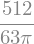

In [16]:
a_10 = calc_a_n(10)

a_10


In [17]:
float(a_10)


In [18]:
# get average l1 metric of many unit l2-examples in dimension 10
np.mean([l1_example(10) for r in range(100000)])


### Writing a Recurrence

With a recurrence relating $a_{n}$ to $a_{n-1}$ we would expect to be able to work out the asymptotic behavior of $a_{n}$. Let's try to eliminate the integrals and pursue that path.

Integration by parts would let us derive the following two identities for positive integer $k$.

$$
s(k) 
 := \int_{\lambda = 0}^{1} \sin((\pi/2) \lambda)^{k} \text{d}\lambda 
 = \frac{\Gamma(k/2 + 1/2)}{\Gamma(k/2 + 1) \sqrt{\pi}}
$$

$$
c(k) 
 := \int_{\lambda = 0}^{1} \cos((\pi/2) \lambda) \sin((\pi/2) \lambda)^{k} \text{d}\lambda 
 = \frac{2}{(k+1) \pi}
$$

So our recurrence is then for $n > 2$:

$$
a_{n} = (c(n-2) + a_{n-1} s(n-1)) / s(n-2)
$$


In [19]:
def gamma_k_plus_half(k: int):
    """Compute gamma(k + 1/2) for non-negative integer k"""
    k = int(k)
    assert k >= 0
    return sqrt(pi) * int(factorial(2 * k)) / (2**(2*k) * int(factorial(k)))

def s(k: int):
    """Compute s() integral."""
    k = int(k)
    assert k >= 1
    if (k & 1) == 0:
        # even
        return gamma_k_plus_half(k/2) / (int(factorial(k/2)) * sqrt(pi))
    else:
        # odd
        return int(factorial((k-1)/2)) / (gamma_k_plus_half((k+1)/2) * sqrt(pi))

def c(k):
    """Compute c() integral"""
    return 2 / ((k + 1) * pi)

def next_a_by_soln(*, n: int, a_previous):
    """Compute a_{n} from a_{n-1} using recurrence formula"""
    n = int(n)
    assert n >= 1
    return (
        (c(n-2) + a_previous * s(n-1)) / s(n-2)
        ).expand().simplify()


We can confirm we have the right functions and recurrence.


In [20]:
next_a_by_soln(n=3, a_previous=a_2)


In [21]:
a_3


In [22]:
next_a_by_soln(n=4, a_previous=a_3)


In [23]:
a_4


We can wrap all of this in a function to get $a_n$ for larger $n$.


In [24]:
soln_cache = {
    1: a_1,
    2: a_2,
}

def calc_a_n_by_soln(n: int):
    """Calculate a_n by advancing next_a_by_soln() (cached)."""
    n = int(n)
    assert n >= 1
    try:
        return soln_cache[n]
    except KeyError:
        pass
    i = np.max(list(soln_cache.keys()))
    a_n = soln_cache[i]
    while i < n:
        i = i + 1
        a_n = next_a_by_soln(n=i, a_previous=a_n)
        soln_cache[i] = a_n
    return a_n


In [25]:
calc_a_n_by_soln(4)


In [26]:
a_4


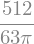

In [27]:
calc_a_n_by_soln(10)


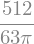

In [28]:
a_10


## The Limiting $a_{n}$

By the linearity of expectation we expect the sum $a_{n}$ to be $n$ times the expected value of $x_{n}$. So we expect:

$$
a_{n} = n c(n-2) / s(n-2)
$$

This is easy to confirm.

In [29]:
4 * c(4 - 2) / s(4 - 2)

In [30]:
a_4

For non-negative $k$ define:

$$
z(k) = \frac{\Gamma(k/2 + 1/2)}{\Gamma(k/2 + 1)}
$$.

First $z(k)$ is decreasing, as using $x \Gamma(x) = \Gamma(x+1)$ we can show that $z(k) / z(k+1) = (k/2 + 1)/(k/2 + 1/2) \gt 1$.

For large $k$ we claim:

$$
\frac{\Gamma(k/2 + 1/2)}{\Gamma(k/2 + 1)} \approx \sqrt{\frac{2}{k}}
$$

Now consider:

$$
\begin{align*} 
\sqrt{z(k-1) z(k)}
 &= \sqrt{\frac{\Gamma(k/2)}{\Gamma(k/2 + 1/2)} \frac{\Gamma(k/2 + 1/2)}{\Gamma(k/2 + 1)}} \\
 &= \sqrt{\frac{\Gamma(k/2)}{\Gamma(k/2 + 1)}} \\
 &= \sqrt{2/k}
\end{align*} 
$$

So $z(k-1) > \sqrt{2/k} > z(k)$. Or $\sqrt{2/k} > z(k) > \sqrt{2/(k+1)}$.

Let's reconfirm this numerically.

In [31]:
def z(n: int):
    """Simpler fn to stand in for s()"""
    n = int(n)
    assert n > 0
    return exp(loggamma(n/2 + 1/2) - loggamma(n/2 + 1))

In [32]:
z_10000 = z(10000)

z_10000

In [33]:
assert float(sqrt(2 / 10000)) > z_10000
assert z_10000 > float(sqrt(2 / (10000 + 1)))

Then $n > 2$ we have:

$$ 
\sqrt{\frac{2}{(n + 1) \pi}} < s(n) < \sqrt{\frac{2}{n \pi}}
$$

$$
\begin{align*} 
c(n) &= \frac{2}{(n+1) \pi} \\
a_{n} &= n c(n-2) / s(n-2) 
\end{align*}
$$

So:

$$
n \frac{2}{(n-1) \pi} \sqrt{\frac{(n-2) \pi}{2}} < a_{n} < n\frac{2}{(n-1) \pi} \sqrt{\frac{(n-1) \pi}{2}} \\
\frac{n}{n-1} \sqrt{\frac{2 (n-2)}{\pi}} < a_{n} < \frac{n}{n-1} \sqrt{\frac{2 (n-1)}{\pi}} 
$$


Which is enough to establish the original claim $a_{n} \approx \sqrt{\frac{2 n}{\pi}}$ for large $n$.



We can recheck that a large that $a_{n} / \sqrt{n}$ is near $\sqrt{2 / \pi}$ for large $n$.


In [34]:
# theoretical a_n / sqrt(n) limit
float(sqrt(2 / pi))


In [35]:
# a_1000 check
a_1000 = float(calc_a_n_by_soln(1000))

a_1000 / 1000**(1/2)

In [36]:
assert float((1000 / (1000 - 1)) * sqrt(2 * (1000 - 2) / pi)) < a_1000
assert a_1000 < float((1000 / (1000 - 1)) * sqrt(2 * (1000 - 1) / pi))

In [37]:
# a_2000 check
float(calc_a_n_by_soln(2000) / 2000**(1/2))


## The local behavior of $a_{n} / \sqrt{n}$

$s(n-2) / s(n)$ has a fairly simple form: $n/(n-1)$.


In [38]:
# s(n-2)/s(n) example
s(38) / s(40)

This means $(a_{n+2} / \sqrt{n+2}) / (a_{n} / \sqrt{n})$ should be manageable.

$$
(a_{n+2} / \sqrt{n+2}) / (a_{n} / \sqrt{n}) = \frac{\sqrt{n}}{\sqrt{n+2}} \frac{(n+2) c(n)}{n c(n-2)} \frac{s(n-2)}{s(n)}
$$

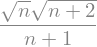

In [39]:
n = sympy.Symbol('n')

ratio = (sqrt(n) / sqrt(n+2)) * ( ((n+2)*c(n)) / (n*c(n-2)) ) * n/(n-1)
ratio


In [40]:
num, den = sympy.fraction(ratio**2)

(den - num).expand()

The denominator is larger than the numerator in our ratio squared. This means the sequence $a_{i + 2*j}$ is strictly decreasing as a sequence in $j$ ($i \in {0, 1}$, $j$ non-negative integer).

In [41]:
# check sequence decreasing when we jump by 2
assert float(a_4 / sqrt(4)) < float(a_2 / sqrt(2))
assert float(a_3 / sqrt(3)) < float(a_1 / sqrt(1))
# other non-step 2 checks
assert float(a_4 / sqrt(4)) < float(a_3 / sqrt(3))
assert float(a_3 / sqrt(3)) < float(a_2 / sqrt(2))
assert float(a_2 / sqrt(2)) < float(a_1 / sqrt(1))

$a_{n} / \sqrt{n}$ is likely a decreasing sequence overall. However our earlier bound isn't tight enough to easily demonstrate this.

## Estimating the Variance

Once we have an estimate for the expected value $a_{n}$ we can in fact get a pretty good estimate of the variance.

Define $v_{n}$ as the variance of $\sum_{i=1}^{n} |x_i|$, where $x_i$ are picked uniformly such that $\sum_{i=1}^{n} x_i^2 = 1$.

By our above arguments and the linearity of expectation, $\text{E}[|x_{i}|]$ for a single coordinate gets close to $\sqrt{2 / (n \pi)}$. So we have:

$$
\begin{align*}
\text{var}(|x_{i}|) &= \text{E}[(|x_{i}| - \text{E}[|x_{i}|])^2] \\
 &\le \text{E}[(|x_{i}| - \sqrt{2 / (n \pi)})^2] \\
 &= \text{E}[|x_{i}|^2 - 2 \sqrt{2 / (n \pi)} |x_{i}| + 2 / (n \pi)] \\
 &= \text{E}[|x_{i}|^2] - 2 \sqrt{2 / (n \pi)} \text{E}[|x_{i}|] + 2 / (n \pi) \\
 &\approx \text{E}[|x_{i}|^2] - 2 \sqrt{2 / (n \pi)} \sqrt{2 / (n \pi)} + 2 / (n \pi) \\
 &= \text{E}[|x_{i}|^2] - 2 / (n \pi) \\
 &= \text{E}[x_{i}^2] - 2 / (n \pi) \\
 &= 1/n - 2 / (n \pi) \\
 &= (1 - 2/\pi) / n
\end{align*}
$$

*If* the coordinates and variances were independent we would expect variance to then be additive and have $v_{n} \approx n (1 - 2/\pi) / n = 1 - 2/\pi$. This isn't they case. The general form for adding variances is: $\text{var}(\sum_i z_i) = \sum_i \text{var}(z_i) + 2 \sum_{i < j} \text{cov}(z_i, z_j)$. Now we expect, but have not checked or established that, these covariances to be negative making our naive heuristic estimate an approximate upper bound.

Under this regime we would expect $\sqrt{v_{n}} \le \sqrt{1 - 2/\pi}$ *independent of the dimension*, and quite small compared to $a_{n} \approx \sqrt{2 n / \pi}$. So we expect that samples drawn are concentrated near our estimate of the mean. However, this naive estimate appears to be too large.

Let's see if this naive estimate stands up.

In [42]:
def mean_and_var(x):
    """return mean and variance of vector entries"""
    return (np.mean(x), np.var(x))

In [43]:
# theoretical mean and var for dimension 1000
(float(sqrt(2 * 1000 / pi)), float(1 - 2 / pi))

In [44]:
# get variance of l1 metric of many unit l2-examples in dimension 1000
mean_and_var([l1_example(1000) for r in range(100000)])

In [45]:
# theoretical mean and var for dimension 10000
(float(sqrt(2 * 10000 / pi)), float(1 - 2 / pi))

In [46]:
# get variance of l1 metric of many unit l2-examples in dimension 10000
mean_and_var([l1_example(10000) for r in range(100000)])

The observed variances are much smaller than the naive estimate. But they do seem to be converting to a small constant. Let's check if our single coordinate estimates were correct.

In [47]:
def l1_example_first_coord(dim: int):
    """Compute l1-norm of a uniformly selected unit l2-vector"""
    dim = int(dim)
    assert dim >= 1
    # generate a uniform L2-norm 1 vector
    v = None
    v_norm_sq = 0
    while v_norm_sq <= 0:
        v = rng.normal(size=dim)
        v_norm_sq = np.dot(v, v)
    v = v / np.sqrt(v_norm_sq)
    # return absolute value of the first coordinate
    return np.abs(v[0])

In [48]:
# heuristic estimates of mean abs first coord and var abs first coord for dimension 1000
(float(sqrt(2 / (1000 * pi))), float((1 - 2/pi) / 1000))

In [49]:
# empirical mean and var of absolute value of first coordinate for dimension 1000
mean_and_var([l1_example_first_coord(1000) for r in range(100000)])

It appears we have good estimates of the coordinate estimates. It just they are dependent and sub-additive.

Let's try and take a look at the general covariance term (by symmetry they all have the same expectations).

In [50]:
def l1_example_first_2_coord_cov(*, dim: int, reps: int = 100000):
    """Compute covariance of absolute values of first two coordinates"""
    dim = int(dim)
    reps = int(reps)
    assert dim >= 2
    assert reps > 0
    frames = []
    for rep in range(reps):
        # generate a uniform L2-norm 1 vector
        v = None
        v_norm_sq = 0
        while v_norm_sq <= 0:
            v = rng.normal(size=dim)
            v_norm_sq = np.dot(v, v)
        v = v / np.sqrt(v_norm_sq)
        # collect absolute value of the first two coordinates
        frames.append(pd.DataFrame({'x0': [np.abs(v[0])], 'x1': [np.abs(v[1])]}))
    d = pd.concat(frames, ignore_index=True)
    return np.cov(d.T)

The theoretic covariance is $\text{E}[|x| |y|] - \text{E}[|x|] \text{E}[|y|]$.
In $2 d$ the expected L1 norm is $4 / \pi$, so each coordinate has
expectation $2 / \pi$. $\text{E}[|x|] \text{E}[|y|]$ is exactly the integral $c(1) = 1/\pi$. This gives us the covariance in $2 d$ is $1 / \pi - ( 2 / \pi )^2$.

In [51]:
# The 2-d covaraince is:
float(1/pi - (2/pi)**2)

In [52]:
# empirically estimate covariance for dimension 2
l1_example_first_2_coord_cov(dim=2)

array([[ 0.09420386, -0.08667095],
       [-0.08667095,  0.09451167]])

In [53]:
# empirically estimate covariance for dimension 10
l1_example_first_2_coord_cov(dim=10)

array([[ 0.03308824, -0.00335686],
       [-0.00335686,  0.03301142]])

The off-diagonal covariance entries do appear to be negative. However they are very small and magnitude, and thus hard to empirically estimate the signs of.

Some work will show for $n > 2$ we have $\text{E}[|x_1| |x_2|] - \text{E}[|x_1|] \text{E}[|x_2|] = \frac{c(n-1)}{s(n-2)} - \left(\frac{n c(n-2)}{s(n-2)}\right)^2$. We can collect the numerator as $c(n-1) s(n-2) - n^2 c(n-2)^2$. This is clearly negative for large $n$, as $c(n) \approx A / n$, and $s(n) \approx B / \sqrt{n}$.

Therefor the off-diagonal covariances are all negative. Thus $v_{n} < 1 - 2/\pi$.

## Application

Barry Rowlingson and John Mount asked the following question ([ref](https://github.com/WinVector/Examples/blob/main/L1L2/exp_l2.md)).

> For a positive integer $n$, take $v_1$, $v_2$ vectors in $\mathbb{R}^n$ with each coordinate generated IID normal mean zero, standard deviation 1. Call the probability that $(||v_1||_1 \ge ||v_2||_1) = (||v_1||_2 \ge ||v_2||_2)$ $p_n$.  What is $\lim_{n \rightarrow \infty} p_n$?

Interestingly $p_n$, which is essentially the AUC of matching the L1 norm to the L2 norm, seems to convert to a constant strictly in the region $(1/2, 1)$.

We could prove this with the following additional tools.

From the Wikipedia [Chi-squared_distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution) page:

> If $X \sim \Chi(k)$ then $\sqrt{2 X}$ is approximately normally distributed with mean $2k−1$ and unit variance (1922, by R. A. Fisher, see (18.23), p. 426 of Johnson).

This means when we generate $v_1$ and $v_2$, we expect their 2-norm to within a constant of each other a constant fraction of the time (independent of dimension!). When two vectors $v_1$ and $v_2$ are close in radius, then the variance of L1 metric depending on orientation of each vector on their spherical shell gives the L1 metric a chance to reverse the L2 ordering.

To complete the proof all we need is to show a constant lower bound on $v_{n}$ (we already have a constant upper bound). We do not have the lower bound at this time.



## Conclusion

For $a_{n}$ the expected value of $\sum_{i=1}^{n} |x_i|$ given $\sum_{i=1}^{n} x_i^2 = 1$ where $x$ is uniformly distributed such, and $v_{n}$ as the variance of this same sum.

We have shown for large $n$: $a_n \approx \sqrt{2 n/ \pi}$. Or, in high dimensions the typical L2 norm-1 vector has an expected L1 norm of about $\sqrt{2 n / \pi}$. We also show the variance $v_n < 1 - \frac{2}{\pi}$ (a constant independent of dimension!).

I think it is pretty neat the large scale behavior is in fact simple.

